# Background

## Goal

To predict when employees are going to quit by understanding the main drivers of employee churn.

## Tasks

Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.


What are the main factors that drive employee churn? Do they make sense? Explain your findings.


If you could add to this data set just one variable that could help explain employee churn, what would that be?

## Dataset

employee_id : id of the employee. Unique by employee per company company_id : company id.

dept : employee dept

seniority : number of yrs of work experience when hired

salary: avg yearly salary of the employee during her tenure within the company join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13

quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

In [8]:
import sys
!{sys.executable} -m pip install pdpbox

     |████████████████████████████████| 57.7MB 5.4MB/s eta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [10]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from numpy.linalg import inv
import pdpbox
from pdpbox import pdp
from pdpbox.info_plots import target_plot

from statsmodels.multivariate.manova import MANOVA
from datetime import date, timedelta

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.tree.export import export_text
from sklearn.tree import plot_tree
from sklearn import preprocessing
import math
from numpy.linalg import det
from matplotlib.pylab import rcParams

In [2]:
dt = pd.read_csv('employee_retention_data.csv',parse_dates=['join_date','quit_date'])

In [3]:
dt.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


## Headcount Estimate

In [4]:
now_date = date(2011, 1, 24)
end_date = date(2015, 12, 31)

In [5]:
sub_cnt = dt[dt['join_date']<=now_date]
cnt_company = pd.DataFrame(sub_cnt.groupby('company_id')['company_id'].count())
sub_quit = sub_cnt[(sub_cnt['quit_date'].isna())|(sub_cnt['quit_date']>now_date)]
quit_company = pd.DataFrame(sub_quit.groupby('company_id')['company_id'].count())
hc = cnt_company-quit_company
hc.columns=['employee_headcount']
hc['company_id']=hc.index
hc['date'] = now_date

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
delta = timedelta(days=1)
while now_date <= end_date:
    now_date += delta
    sub_cnt = dt[dt['join_date']<=now_date]
    cnt_company = pd.DataFrame(sub_cnt.groupby('company_id')['company_id'].count())
    sub_quit = sub_cnt[(sub_cnt['quit_date'].isna())|(sub_cnt['quit_date']>now_date)]
    quit_company = pd.DataFrame(sub_quit.groupby('company_id')['company_id'].count())
    hc1 = cnt_company-quit_company
    hc1.columns=['employee_headcount']
    hc1['company_id']=hc1.index
    hc1['date'] = now_date
    hc = pd.concat([hc,hc1])

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  after removing the cwd from sys.path.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [7]:
hc.shape

(21563, 3)

In [ ]:
hc.head()

## Exploratory Analysis

In [4]:
dt['quit_or_not'] = dt['quit_date'].isna()

In [61]:
dt = pd.get_dummies(dt, prefix_sep="__",columns=['dept'])
dt = pd.get_dummies(dt, prefix_sep="__",columns=['company_id'])

KeyError: "None of [Index(['dept'], dtype='object')] are in the [columns]"

In [62]:
dt['join_date_int'] = dt['join_date'].astype(int)/ 10**15

In [63]:
dt.columns

Index(['employee_id', 'seniority', 'salary', 'join_date', 'quit_date',
       'quit_or_not', 'dept__customer_service', 'dept__data_science',
       'dept__design', 'dept__engineer', 'dept__marketing', 'dept__sales',
       'company_id__1', 'company_id__2', 'company_id__3', 'company_id__4',
       'company_id__5', 'company_id__6', 'company_id__7', 'company_id__8',
       'company_id__9', 'company_id__10', 'company_id__11', 'company_id__12',
       'join_date_int'],
      dtype='object')

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63d59c438>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63d557b70>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63d50bf60>},
    x display_column  value_lower  value_upper percentile_column  \
 0  0         [1, 4)          1.0          4.0        [0, 11.11)   
 1  1         [4, 7)          4.0          7.0    [11.11, 22.22)   
 2  2         [7, 9)          7.0          9.0    [22.22, 33.33)   
 3  3        [9, 12)          9.0         12.0    [33.33, 44.44)   
 4  4       [12, 15)         12.0         15.0    [44.44, 55.56)   
 5  5       [15, 18)         15.0         18.0    [55.56, 66.67)   
 6  6       [18, 22)         18.0         22.0    [66.67, 77.78)   
 7  7       [22, 25)         22.0         25.0    [77.78, 88.89)   
 8  8       [25, 99]         25.0         99.0      [88.89, 100]   
 
    percentile_lower  percentile_upper  count  quit_or_not  
 0 

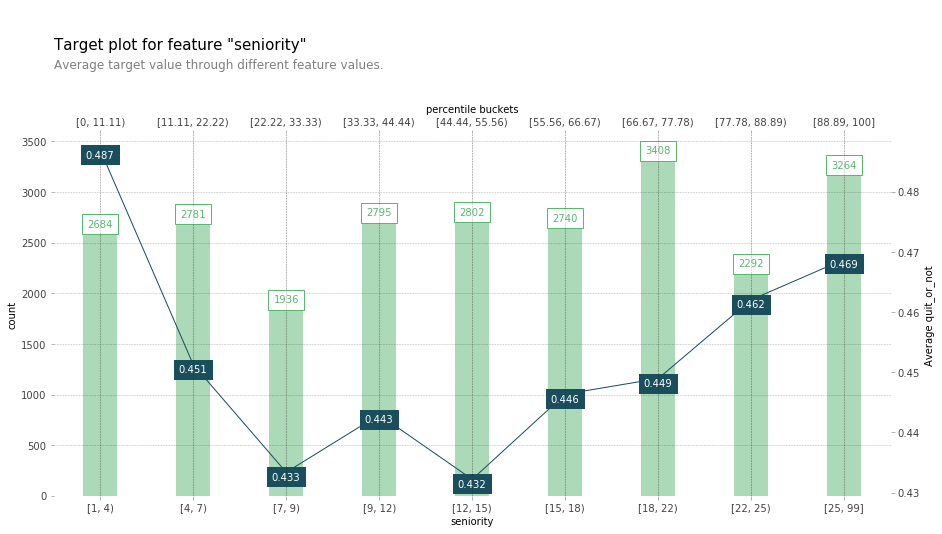

In [16]:
target_plot(
    df=dt, feature='seniority', feature_name='seniority', target='quit_or_not', show_percentile=True)

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63cbbfac8>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63cb67080>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63cb74320>},
    x    display_column  value_lower  value_upper percentile_column  \
 0  0    [17000, 55000)      17000.0      55000.0        [0, 11.11)   
 1  1    [55000, 74000)      55000.0      74000.0    [11.11, 22.22)   
 2  2    [74000, 94000)      74000.0      94000.0    [22.22, 33.33)   
 3  3   [94000, 113000)      94000.0     113000.0    [33.33, 44.44)   
 4  4  [113000, 134000)     113000.0     134000.0    [44.44, 55.56)   
 5  5  [134000, 163000)     134000.0     163000.0    [55.56, 66.67)   
 6  6  [163000, 195000)     163000.0     195000.0    [66.67, 77.78)   
 7  7  [195000, 242000)     195000.0     242000.0    [77.78, 88.89)   
 8  8  [242000, 408000]     242000.0     408000.0      [88.89, 100]   
 
    percentile_lower  percentile_u

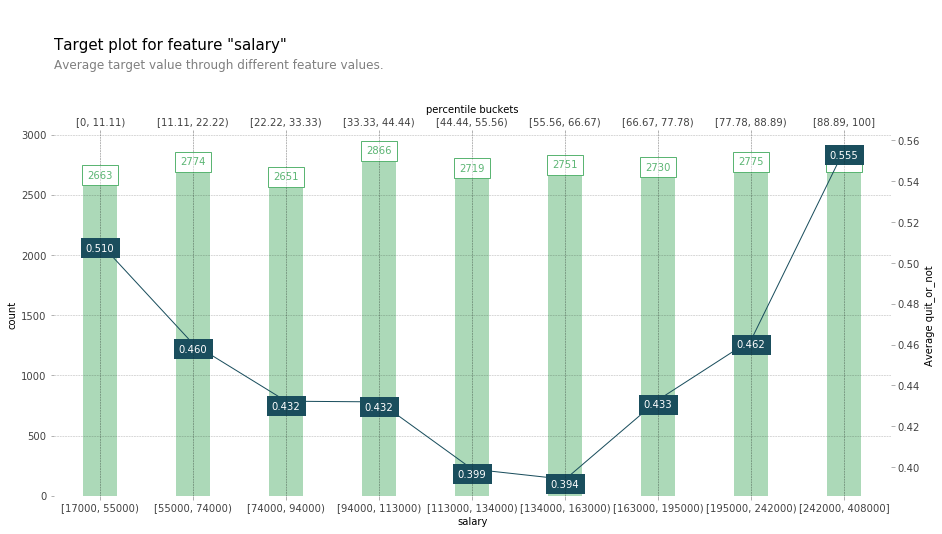

In [17]:
target_plot(
    df=dt, feature='salary', feature_name='salary', target='quit_or_not', show_percentile=True)

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63c8a1828>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc6096987b8>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc60962e8d0>},
    x      display_column  value_lower  value_upper percentile_column  \
 0  0  [1295.83, 1313.37)    1295.8272    1313.3664        [0, 11.11)   
 1  1  [1313.37, 1329.78)    1313.3664    1329.7824    [11.11, 22.22)   
 2  2  [1329.78, 1346.72)    1329.7824    1346.7168    [22.22, 33.33)   
 3  3  [1346.72, 1363.56)    1346.7168    1363.5648    [33.33, 44.44)   
 4  4   [1363.56, 1381.1)    1363.5648    1381.1040    [44.44, 55.56)   
 5  5   [1381.1, 1398.04)    1381.1040    1398.0384    [55.56, 66.67)   
 6  6  [1398.04, 1415.58)    1398.0384    1415.5776    [66.67, 77.78)   
 7  7   [1415.58, 1432.6)    1415.5776    1432.5984    [77.78, 88.89)   
 8  8   [1432.6, 1449.71]    1432.5984    1449.7056      [88.89, 100]   
 
    percentile

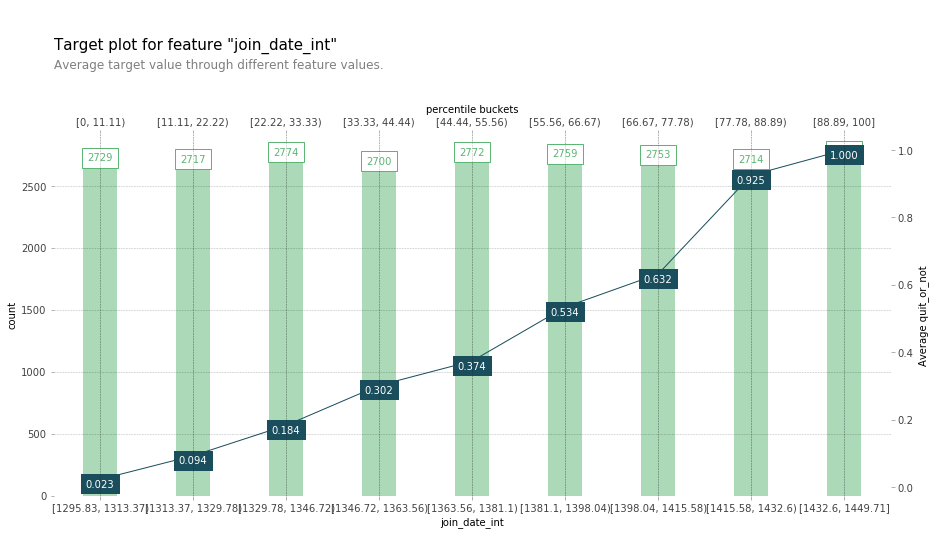

In [64]:
target_plot(
    df=dt, feature='join_date_int', feature_name='join_date_int', target='quit_or_not', show_percentile=True)

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63fb17550>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63f82c5f8>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63d7cfb70>},
    x          display_column  count  quit_or_not
 0  0  dept__customer_service   9180     0.445098
 1  1      dept__data_science   3190     0.472727
 2  2            dept__design   1380     0.436232
 3  3          dept__engineer   4613     0.487969
 4  4         dept__marketing   3167     0.437007
 5  5             dept__sales   3172     0.429067)

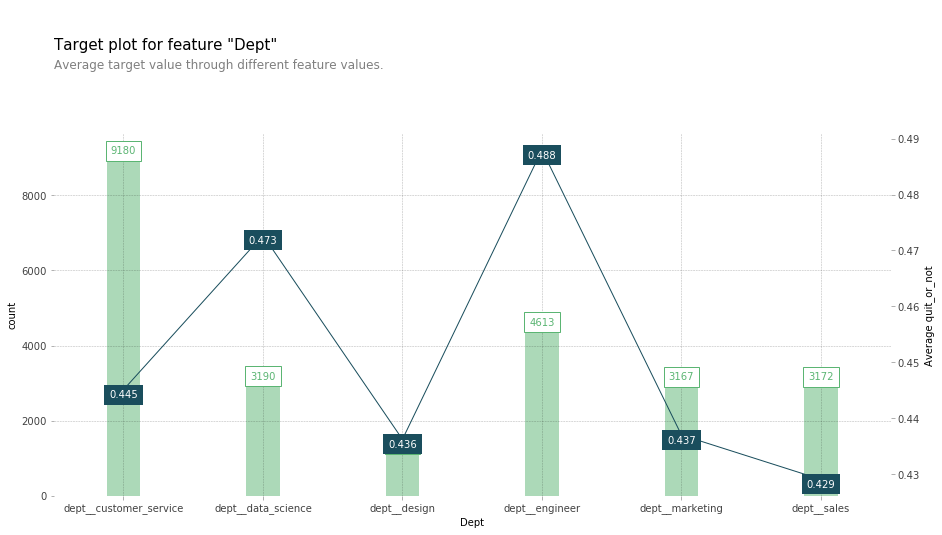

In [14]:
target_plot(df=dt, feature=['dept__customer_service', 'dept__data_science',
       'dept__design', 'dept__engineer', 'dept__marketing', 'dept__sales'],
    feature_name='Dept', target='quit_or_not')

(<Figure size 1080x648 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63d7058d0>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63d6c1dd8>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc63d67f390>},
      x  display_column  count  quit_or_not
 0    0   company_id__1   8486     0.455456
 1    1   company_id__2   4222     0.477499
 2    2   company_id__3   2749     0.443070
 3    3   company_id__4   2062     0.440834
 4    4   company_id__5   1755     0.439886
 5    5   company_id__6   1291     0.448490
 6    6   company_id__7   1224     0.434641
 7    7   company_id__8   1047     0.446991
 8    8   company_id__9    961     0.449532
 9    9  company_id__10    865     0.445087
 10  10  company_id__11     16     0.250000
 11  11  company_id__12     24     0.500000)

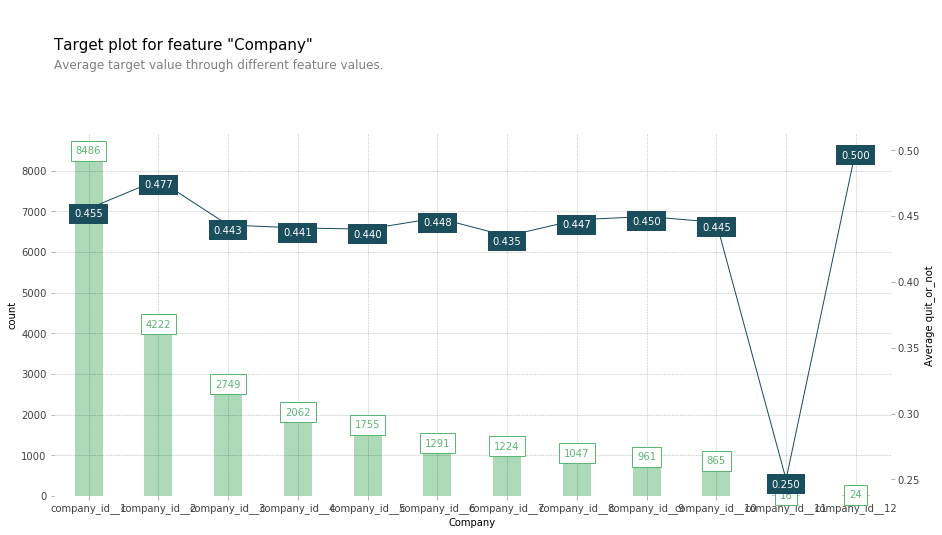

In [15]:
target_plot(df=dt, feature=['company_id__1', 'company_id__2', 'company_id__3', 'company_id__4',
       'company_id__5', 'company_id__6', 'company_id__7', 'company_id__8',
       'company_id__9', 'company_id__10', 'company_id__11', 'company_id__12'],
    feature_name='Company', target='quit_or_not')

Findings:

1. seniority: There are some recognizable patterns since the ratios of quitting are low at both ends and the ratios tend to be higher in the middle.
2. salary: It is very clear that there are strong associations between salary and employee churn. The trend is a U-shape line. The difference between the peak and the lowest point is large and the trend is consistent. 
3. join_date: There is a clear increasing trend beween the join_date and quitting rate.
4. dept: For Sales department, Marketing department and Design department tend to have higher quitting rate. But the difference is not strong.
5. company: Company 11 and company 12 have less than 50 data points in total. Although the quitting rates of these two companies is noticeably different from those of other companies. This reasoning might not be substaintial enough.

Conclusion:

The most important factors might be join_date, salary, seniority.


## Decision Tree Model Building

In [19]:
dt1 = dt.fillna( max(dt['quit_date'])+ pd.to_timedelta(23, unit='d')) # for the working employees, their quit date is set to be 2016-1-1.

In [20]:
dt1['wrk_time'] = dt1['quit_date']-dt1['join_date']

In [122]:
dt1.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_or_not,wrk_time
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,False,585 days
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,False,340 days
2,927315.0,4,marketing,14,101000.0,2014-10-13,2016-01-01,True,445 days
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,False,389 days
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,False,1040 days


In [21]:
dt1['join_date_int'] = dt1['join_date'].astype(int)/ 10**15
#dt1['quit_date_int'] = dt1['quit_date'].astype(int)/ 10**15
dt1['wrk_time_int'] = dt1['wrk_time'].dt.days

In [125]:
dt1.shape

(24702, 27)

In [129]:
dt1.columns

Index(['employee_id', 'seniority', 'salary', 'join_date', 'quit_date',
       'quit_or_not', 'wrk_time', 'dept__customer_service',
       'dept__data_science', 'dept__design', 'dept__engineer',
       'dept__marketing', 'dept__sales', 'company_id__1', 'company_id__2',
       'company_id__3', 'company_id__4', 'company_id__5', 'company_id__6',
       'company_id__7', 'company_id__8', 'company_id__9', 'company_id__10',
       'company_id__11', 'company_id__12', 'join_date_int', 'wrk_time_int'],
      dtype='object')

### Adding the working time variable==>join_date, working_time

In [54]:
feature_name = ['seniority', 'salary','dept__customer_service',
       'dept__data_science', 'dept__design', 'dept__engineer',
       'dept__marketing', 'dept__sales', 'company_id__1', 'company_id__2',
       'company_id__3', 'company_id__4', 'company_id__5', 'company_id__6',
       'company_id__7', 'company_id__8', 'company_id__9', 'company_id__10',
       'company_id__11', 'company_id__12', 'join_date_int', 'wrk_time_int']
X = dt1[feature_name]
Y = dt1['quit_or_not']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1) 

In [55]:
clf_gini = DecisionTreeClassifier(criterion = "gini", 
            random_state = 1,max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [56]:
y_pred = clf_gini.predict(X_test) 
confusion_matrix(y_test, y_pred)

array([[3704,  392],
       [ 273, 3042]])

In [57]:
accuracy_score(y_test,y_pred)*100

91.02685197679125

In [58]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n       False       0.93      0.90      0.92      4096\n        True       0.89      0.92      0.90      3315\n\n    accuracy                           0.91      7411\n   macro avg       0.91      0.91      0.91      7411\nweighted avg       0.91      0.91      0.91      7411\n'

In [59]:
sum(dt['quit_or_not'])/dt.shape[0]

0.453080722208728

In [60]:
f_imp = pd.DataFrame(clf_gini.feature_importances_)
f_imp.columns = ['importance']
f_imp['feature'] = feature_name
f_imp[f_imp['importance']>0]

,importance,feature
20,0.663903,join_date_int
21,0.336097,wrk_time_int


In [139]:
export_text(clf_gini, feature_names=feature_name)

'|--- join_date_int <= 1387.20\n|   |--- wrk_time_int <= 745.50\n|   |   |--- class: False\n|   |--- wrk_time_int >  745.50\n|   |   |--- join_date_int <= 1346.07\n|   |   |   |--- class: False\n|   |   |--- join_date_int >  1346.07\n|   |   |   |--- class: True\n|--- join_date_int >  1387.20\n|   |--- join_date_int <= 1418.04\n|   |   |--- wrk_time_int <= 395.50\n|   |   |   |--- class: False\n|   |   |--- wrk_time_int >  395.50\n|   |   |   |--- class: True\n|   |--- join_date_int >  1418.04\n|   |   |--- join_date_int <= 1421.06\n|   |   |   |--- class: True\n|   |   |--- join_date_int >  1421.06\n|   |   |   |--- class: True\n'

[Text(1888.6153846153845, 2378.25, 'join_date_int <= 1387.195\nentropy = 0.496\nsamples = 17291\nvalue = [9414, 7877]'),
 Text(686.7692307692307, 1698.75, 'wrk_time_int <= 745.5\nentropy = 0.342\nsamples = 10318\nvalue = [8062, 2256]'),
 Text(343.38461538461536, 1019.25, 'entropy = 0.0\nsamples = 5301\nvalue = [5301, 0]'),
 Text(1030.1538461538462, 1019.25, 'join_date_int <= 1346.069\nentropy = 0.495\nsamples = 5017\nvalue = [2761, 2256]'),
 Text(686.7692307692307, 339.75, 'entropy = 0.335\nsamples = 2714\nvalue = [2137, 577]'),
 Text(1373.5384615384614, 339.75, 'entropy = 0.395\nsamples = 2303\nvalue = [624, 1679]'),
 Text(3090.461538461538, 1698.75, 'join_date_int <= 1418.04\nentropy = 0.313\nsamples = 6973\nvalue = [1352, 5621]'),
 Text(2403.6923076923076, 1019.25, 'wrk_time_int <= 395.5\nentropy = 0.471\nsamples = 3393\nvalue = [1291, 2102]'),
 Text(2060.3076923076924, 339.75, 'entropy = 0.078\nsamples = 1027\nvalue = [985, 42]'),
 Text(2747.076923076923, 339.75, 'entropy = 0.225\n

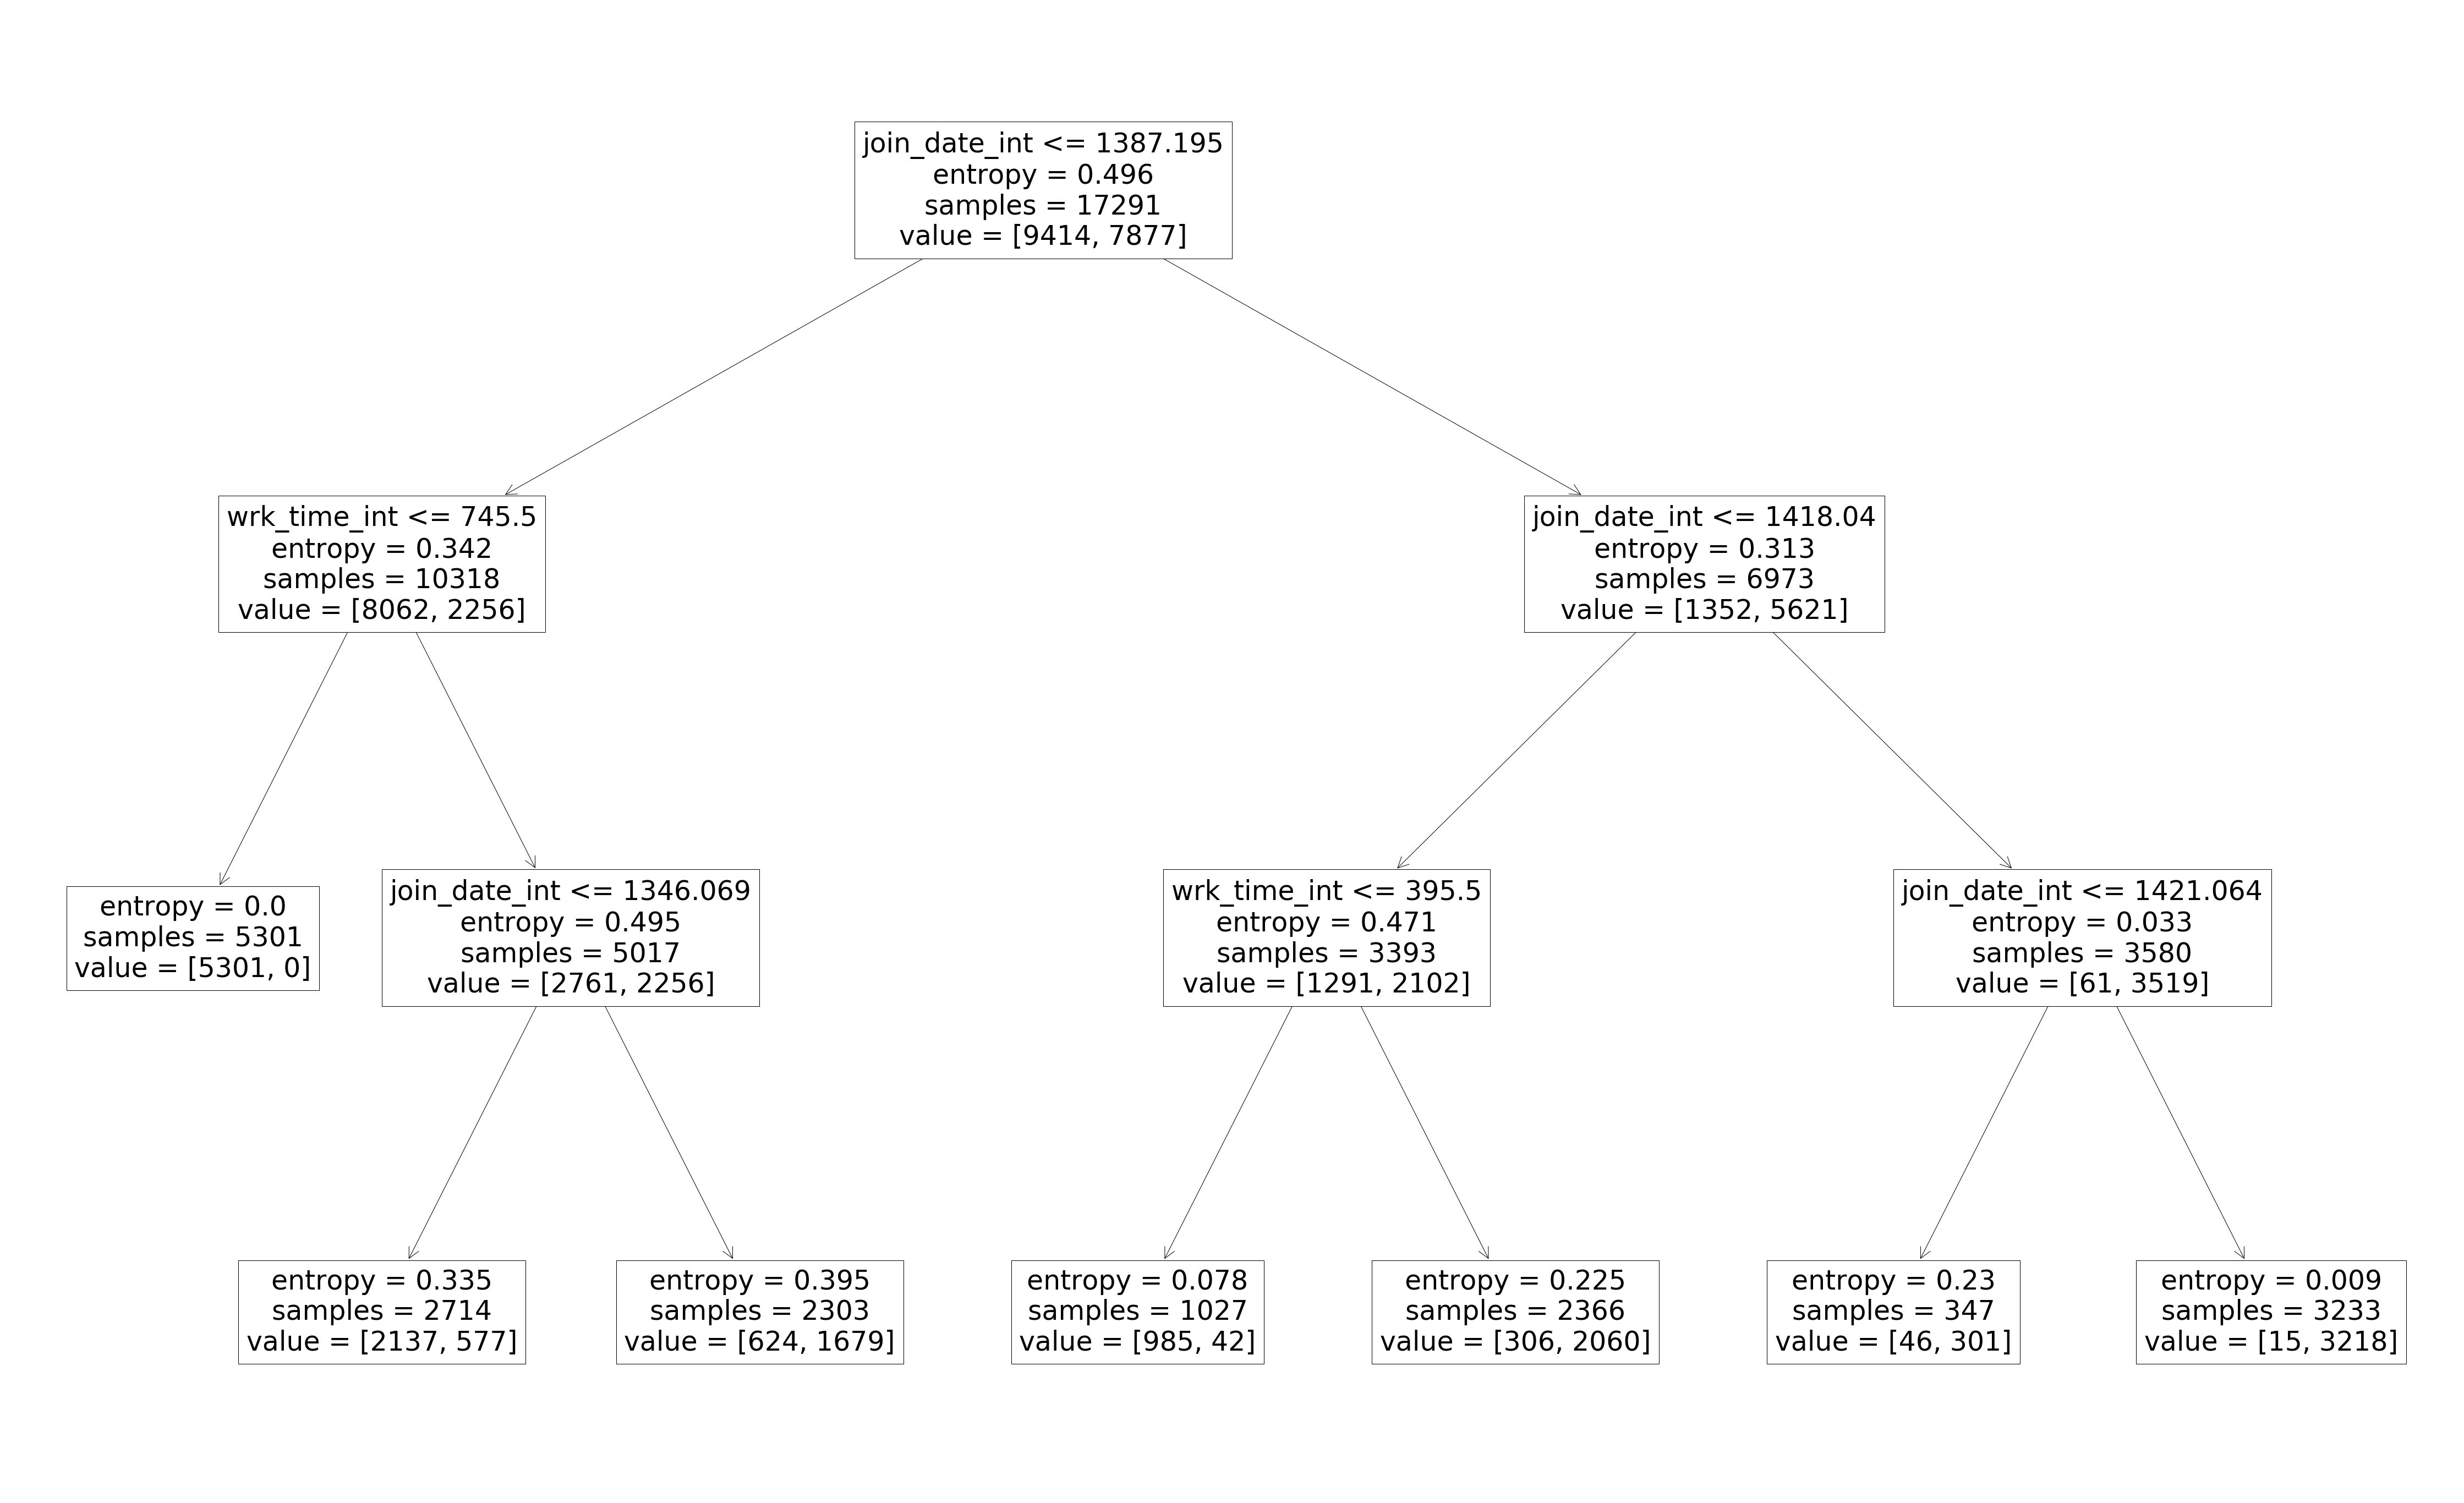

In [148]:
rcParams['figure.figsize'] = 80,50
plot_tree(clf_gini,feature_names=feature_name) 

According to the decision tree model, the most important variables are join_date and working_time(which is the difference between join_date and quit_date). However, acctually, the working time is not the information we can collect before employee leaves. So, I am going to remove this variable and build decision model again.

### Removing the working time variable==>join_date, salary

In [47]:
feature_name = ['seniority', 'salary','dept__customer_service',
       'dept__data_science', 'dept__design', 'dept__engineer',
       'dept__marketing', 'dept__sales', 'company_id__1', 'company_id__2',
       'company_id__3', 'company_id__4', 'company_id__5', 'company_id__6',
       'company_id__7', 'company_id__8', 'company_id__9', 'company_id__10',
       'company_id__11', 'company_id__12', 'join_date_int']
X = dt1[feature_name]
Y = dt1['quit_or_not']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1) 

In [48]:
clf_gini = DecisionTreeClassifier(criterion = "gini", 
            random_state = 1,max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [49]:
y_pred = clf_gini.predict(X_test) 
confusion_matrix(y_test, y_pred)

array([[3425,  671],
       [ 818, 2497]])

In [50]:
accuracy_score(y_test,y_pred)*100

79.90824450141682

In [51]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n       False       0.81      0.84      0.82      4096\n        True       0.79      0.75      0.77      3315\n\n    accuracy                           0.80      7411\n   macro avg       0.80      0.79      0.80      7411\nweighted avg       0.80      0.80      0.80      7411\n'

In [52]:
f_imp = pd.DataFrame(clf_gini.feature_importances_)
f_imp.columns = ['importance']
f_imp['feature'] = feature_name
f_imp[f_imp['importance']>0]

,importance,feature
1,0.01815,salary
20,0.98185,join_date_int


In [53]:
export_text(clf_gini, feature_names=feature_name)

'|--- join_date_int <= 1387.20\n|   |--- join_date_int <= 1347.88\n|   |   |--- join_date_int <= 1324.04\n|   |   |   |--- class: False\n|   |   |--- join_date_int >  1324.04\n|   |   |   |--- class: False\n|   |--- join_date_int >  1347.88\n|   |   |--- salary <= 247500.00\n|   |   |   |--- class: False\n|   |   |--- salary >  247500.00\n|   |   |   |--- class: True\n|--- join_date_int >  1387.20\n|   |--- join_date_int <= 1418.04\n|   |   |--- salary <= 222500.00\n|   |   |   |--- class: True\n|   |   |--- salary >  222500.00\n|   |   |   |--- class: True\n|   |--- join_date_int >  1418.04\n|   |   |--- join_date_int <= 1421.06\n|   |   |   |--- class: True\n|   |   |--- join_date_int >  1421.06\n|   |   |   |--- class: True\n'

[Text(2232.0, 2378.25, 'join_date_int <= 1387.195\nentropy = 0.496\nsamples = 17291\nvalue = [9414, 7877]'),
 Text(1116.0, 1698.75, 'join_date_int <= 1347.883\nentropy = 0.342\nsamples = 10318\nvalue = [8062, 2256]'),
 Text(558.0, 1019.25, 'join_date_int <= 1324.037\nentropy = 0.189\nsamples = 5853\nvalue = [5234, 619]'),
 Text(279.0, 339.75, 'entropy = 0.085\nsamples = 3136\nvalue = [2997, 139]'),
 Text(837.0, 339.75, 'entropy = 0.291\nsamples = 2717\nvalue = [2237, 480]'),
 Text(1674.0, 1019.25, 'salary <= 247500.0\nentropy = 0.464\nsamples = 4465\nvalue = [2828, 1637]'),
 Text(1395.0, 339.75, 'entropy = 0.449\nsamples = 3959\nvalue = [2609, 1350]'),
 Text(1953.0, 339.75, 'entropy = 0.491\nsamples = 506\nvalue = [219, 287]'),
 Text(3348.0, 1698.75, 'join_date_int <= 1418.04\nentropy = 0.313\nsamples = 6973\nvalue = [1352, 5621]'),
 Text(2790.0, 1019.25, 'salary <= 222500.0\nentropy = 0.471\nsamples = 3393\nvalue = [1291, 2102]'),
 Text(2511.0, 339.75, 'entropy = 0.482\nsamples = 2865

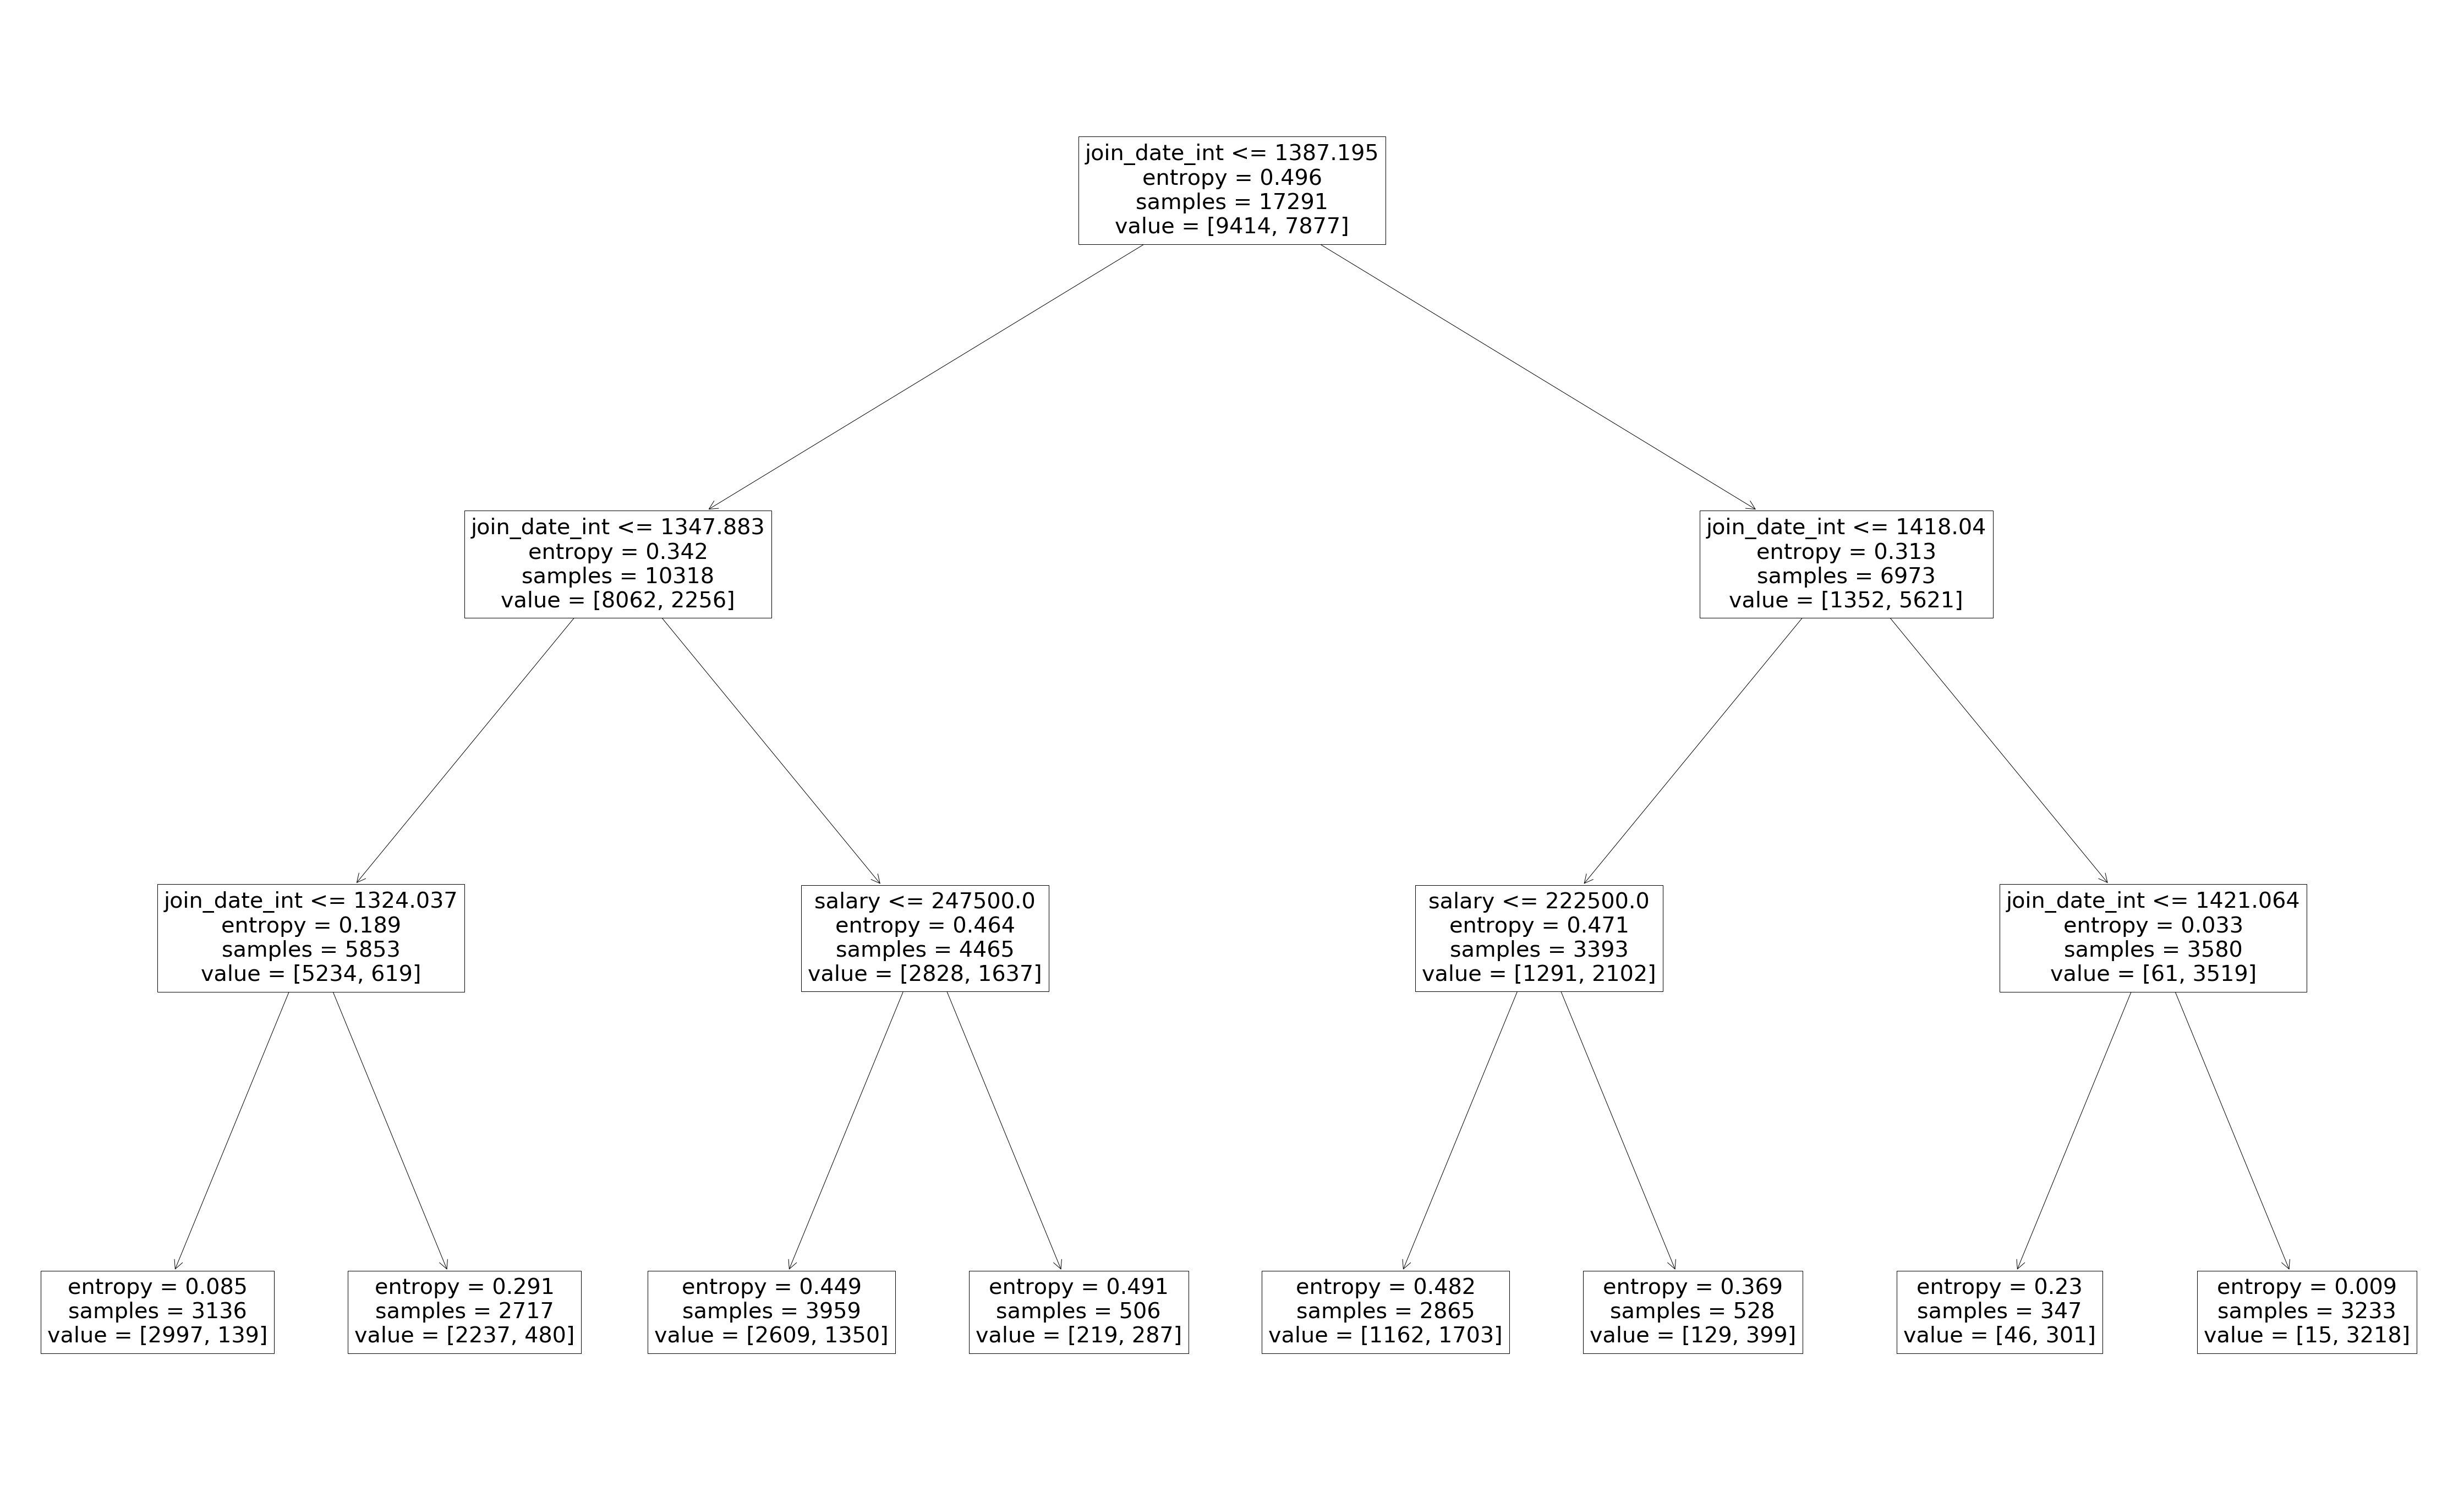

In [31]:
rcParams['figure.figsize'] = 80,50
plot_tree(clf_gini,feature_names=feature_name) 

### Removing join_date ==> Salary, Dept_sales, Seniority

In [32]:
feature_name = ['seniority', 'salary','dept__customer_service',
       'dept__data_science', 'dept__design', 'dept__engineer',
       'dept__marketing', 'dept__sales', 'company_id__1', 'company_id__2',
       'company_id__3', 'company_id__4', 'company_id__5', 'company_id__6',
       'company_id__7', 'company_id__8', 'company_id__9', 'company_id__10',
       'company_id__11', 'company_id__12']
X = dt1[feature_name]
Y = dt1['quit_or_not']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1) 

In [33]:
clf_gini = DecisionTreeClassifier(criterion = "gini", 
            random_state = 1,max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [34]:
y_pred = clf_gini.predict(X_test) 
confusion_matrix(y_test, y_pred)

array([[3400,  696],
       [2605,  710]])

In [35]:
accuracy_score(y_test,y_pred)*100

55.45810282013224

In [36]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n       False       0.57      0.83      0.67      4096\n        True       0.50      0.21      0.30      3315\n\n    accuracy                           0.55      7411\n   macro avg       0.54      0.52      0.49      7411\nweighted avg       0.54      0.55      0.51      7411\n'

In [46]:
f_imp = pd.DataFrame(clf_gini.feature_importances_)
f_imp.columns = ['importance']
f_imp['feature'] = feature_name
f_imp[f_imp['importance']>0]

,importance,feature
0,0.017423,seniority
1,0.950792,salary
7,0.031785,dept__sales


In [38]:
export_text(clf_gini, feature_names=feature_name)

'|--- salary <= 246500.00\n|   |--- salary <= 58500.00\n|   |   |--- dept__sales <= 0.50\n|   |   |   |--- class: True\n|   |   |--- dept__sales >  0.50\n|   |   |   |--- class: False\n|   |--- salary >  58500.00\n|   |   |--- salary <= 181500.00\n|   |   |   |--- class: False\n|   |   |--- salary >  181500.00\n|   |   |   |--- class: False\n|--- salary >  246500.00\n|   |--- salary <= 273500.00\n|   |   |--- seniority <= 20.50\n|   |   |   |--- class: True\n|   |   |--- seniority >  20.50\n|   |   |   |--- class: False\n|   |--- salary >  273500.00\n|   |   |--- salary <= 365500.00\n|   |   |   |--- class: True\n|   |   |--- salary >  365500.00\n|   |   |   |--- class: True\n'

[Text(2232.0, 2378.25, 'salary <= 246500.0\nentropy = 0.496\nsamples = 17291\nvalue = [9414, 7877]'),
 Text(1116.0, 1698.75, 'salary <= 58500.0\nentropy = 0.493\nsamples = 15463\nvalue = [8647, 6816]'),
 Text(558.0, 1019.25, 'dept__sales <= 0.5\nentropy = 0.5\nsamples = 2213\nvalue = [1086, 1127]'),
 Text(279.0, 339.75, 'entropy = 0.499\nsamples = 1890\nvalue = [906, 984]'),
 Text(837.0, 339.75, 'entropy = 0.493\nsamples = 323\nvalue = [180, 143]'),
 Text(1674.0, 1019.25, 'salary <= 181500.0\nentropy = 0.49\nsamples = 13250\nvalue = [7561, 5689]'),
 Text(1395.0, 339.75, 'entropy = 0.488\nsamples = 10452\nvalue = [6048, 4404]'),
 Text(1953.0, 339.75, 'entropy = 0.497\nsamples = 2798\nvalue = [1513, 1285]'),
 Text(3348.0, 1698.75, 'salary <= 273500.0\nentropy = 0.487\nsamples = 1828\nvalue = [767, 1061]'),
 Text(2790.0, 1019.25, 'seniority <= 20.5\nentropy = 0.498\nsamples = 577\nvalue = [270, 307]'),
 Text(2511.0, 339.75, 'entropy = 0.489\nsamples = 266\nvalue = [113, 153]'),
 Text(3069

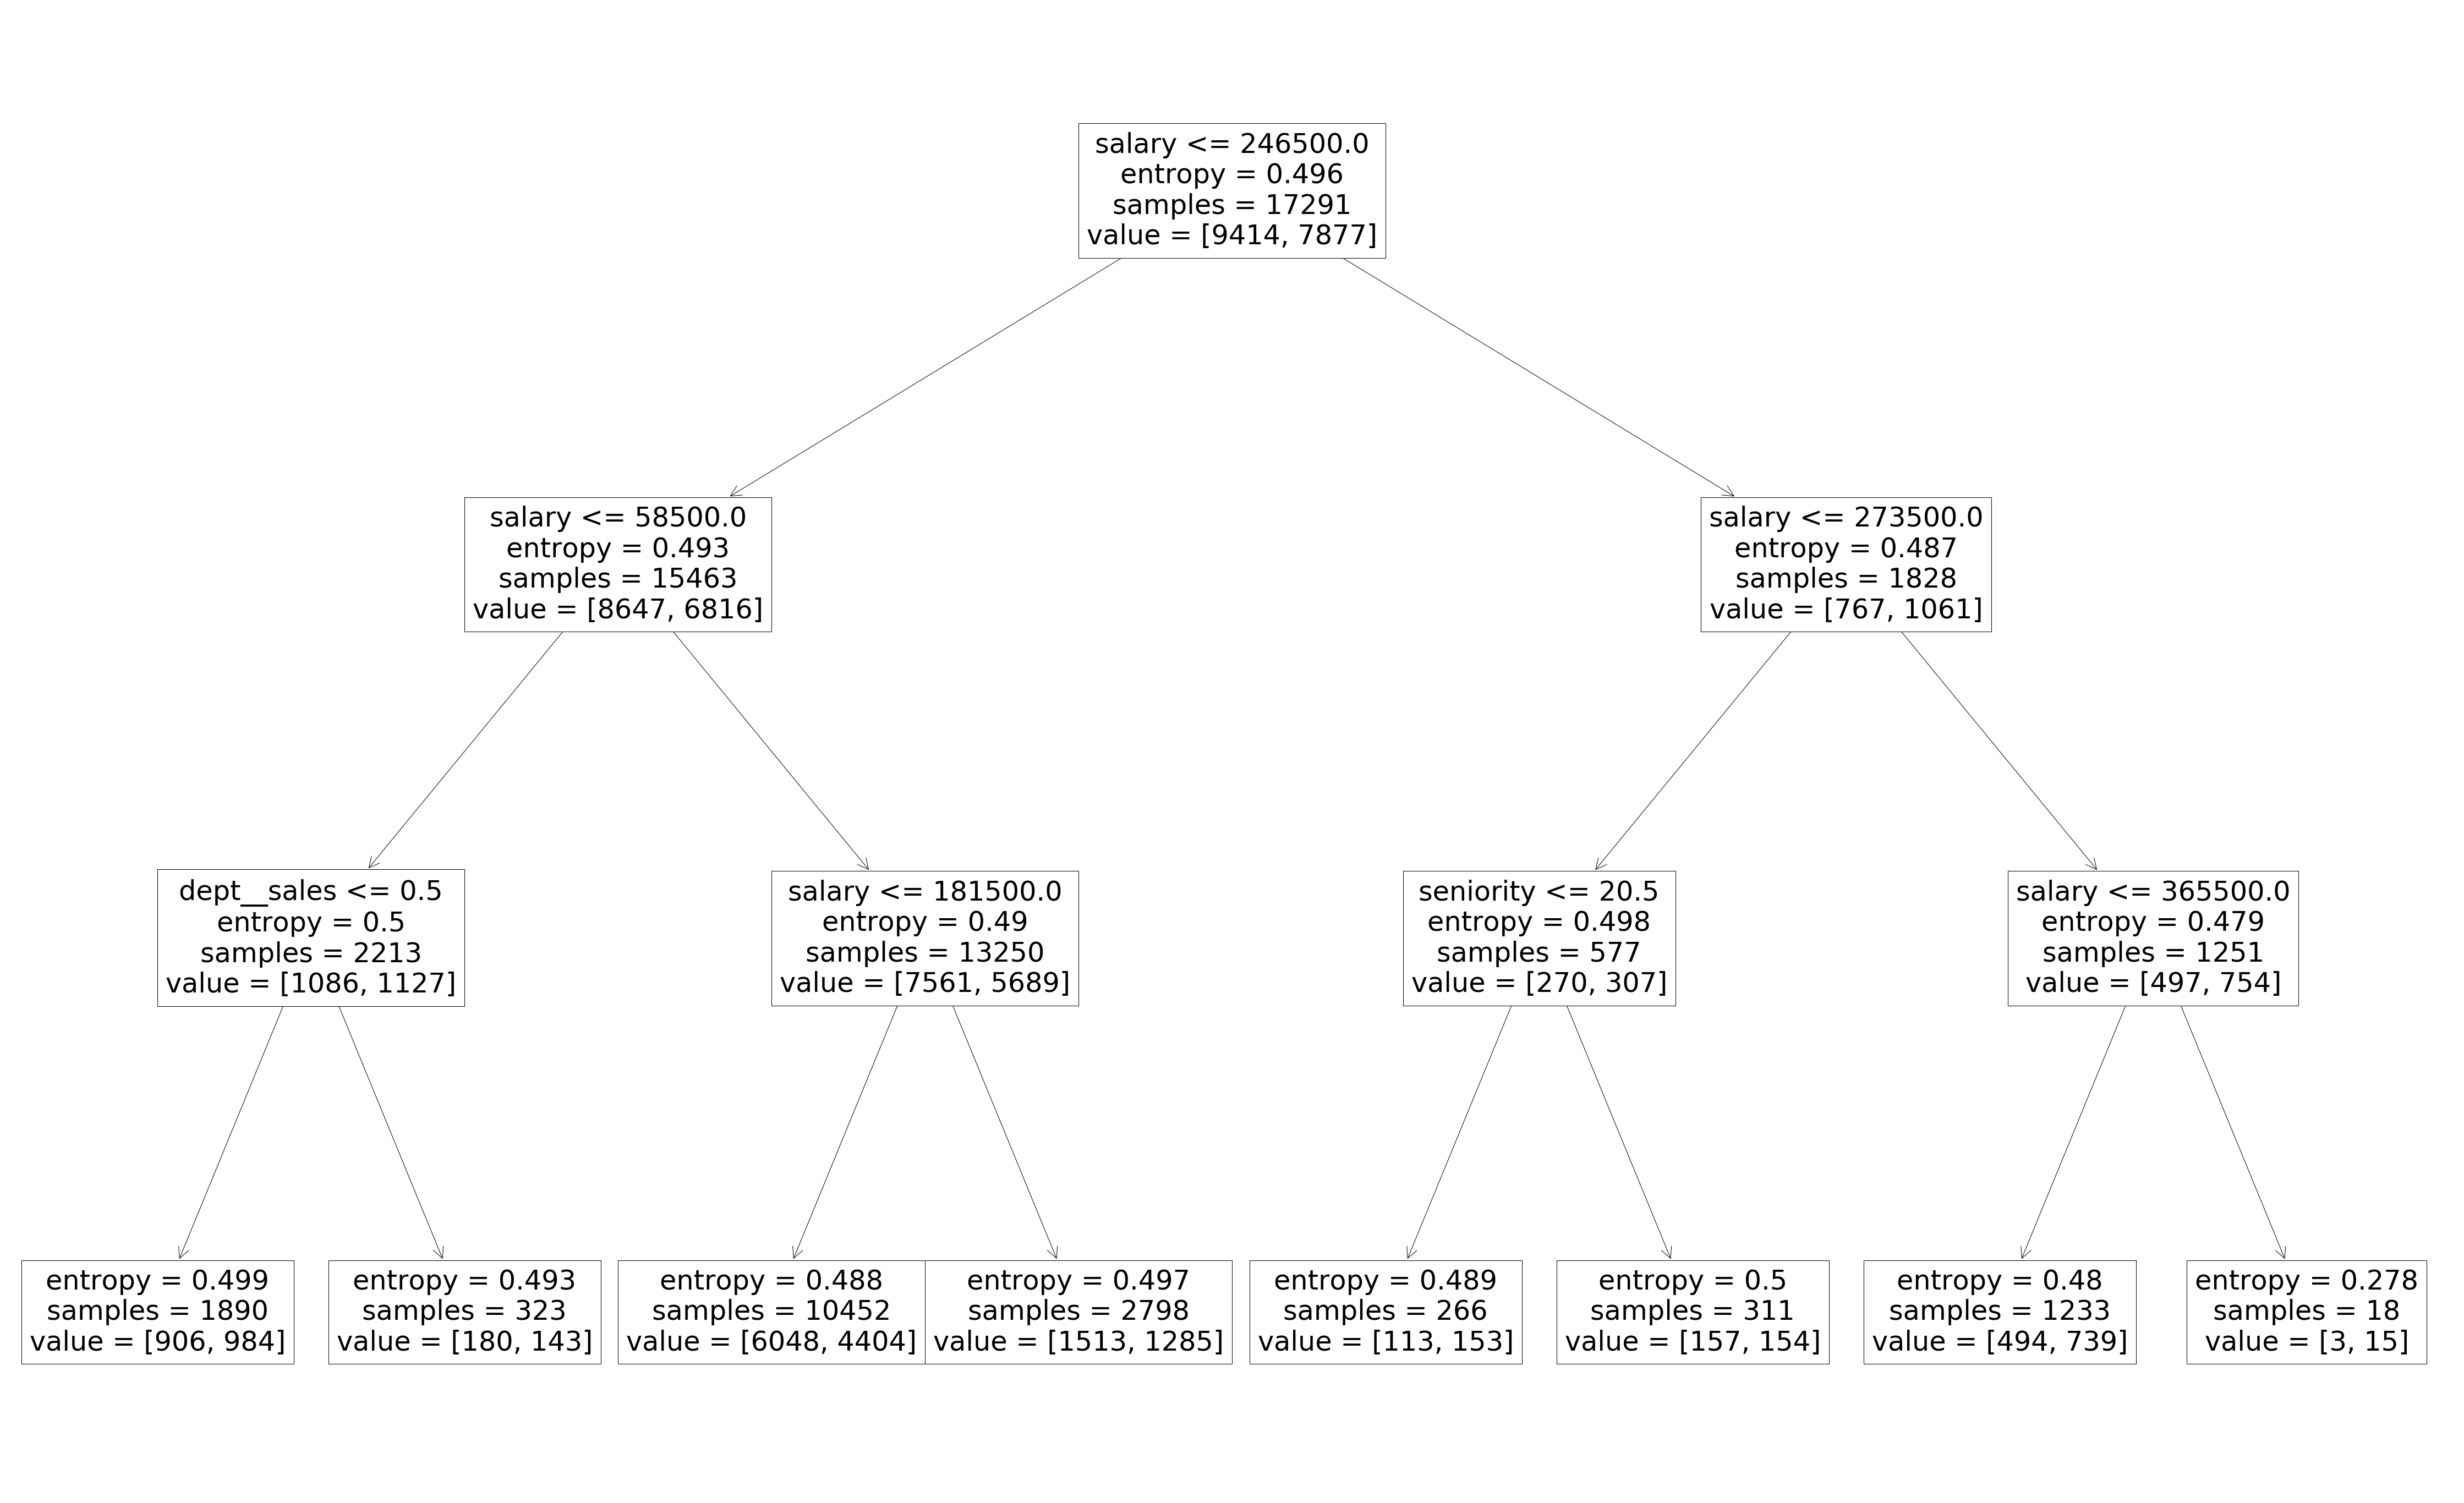

In [39]:
rcParams['figure.figsize'] = 80,50
plot_tree(clf_gini,feature_names=feature_name) 

### Conclusion

The most important variables are join_date, then, salary, department(sales) and seniority.

## Explanation for the most important variable.

## Other Variables needed

I think what variable I would need depends on what kind of improvements we hope to make and how much efforts we would like to take.

1. If we would love to improve the recruiting process first:
The data about some testing results can be helpful, for example, the data from the online accessments the candidates take.
Although some geographic or personal information may be helpful, these might be too personal and there are chances that it may enhance the bias in the model. I would not collect these data.

2. If we would love to improve the working environment first:
I may collect information like the working hours, working schdule, the evaluation methods, commute time, working site location. If we find any of these influencing the employee churn, then we can make a feasible plan to take some measures.

## Approach 2: build a Regression Model

In [16]:
dt2 = dt[~dt['quit_date'].isna()][['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date',
       'quit_date']]

In [17]:
dt2.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30


In [18]:
dt2['wrk_time'] = dt2['quit_date']-dt2['join_date']
dt2 = pd.get_dummies(dt2, prefix_sep="__",columns=['dept'])
dt2['join_date_int'] = dt2['join_date'].astype(int)/ 10**15
dt2['quit_date_int'] = dt2['quit_date'].astype(int)/ 10**15
dt2['wrk_time_int'] = dt2['wrk_time'].dt.days

In [19]:
dt2 = pd.get_dummies(dt2, prefix_sep="__",columns=['company_id'])

In [20]:
dt2.columns

Index(['employee_id', 'seniority', 'salary', 'join_date', 'quit_date',
       'wrk_time', 'dept__customer_service', 'dept__data_science',
       'dept__design', 'dept__engineer', 'dept__marketing', 'dept__sales',
       'join_date_int', 'quit_date_int', 'wrk_time_int', 'company_id__1',
       'company_id__2', 'company_id__3', 'company_id__4', 'company_id__5',
       'company_id__6', 'company_id__7', 'company_id__8', 'company_id__9',
       'company_id__10', 'company_id__11', 'company_id__12'],
      dtype='object')

# Note

## Common Model
Decision Trees (rpart)
Boosted Models (adaboost)
Random Forests (rf)
Support Vector Models (svm)
Linear Models (glm)

## Common Goal


## Good Practices
1. Predicting and preventing turnover at HP
 By using predictive models, they generated what they called a “Flight Risk” score. This score predicted the likelihood of leaving of each of HP’s 300,000 plus employees. Based on the data, they could see why employees would leave HP. Higher pay, promotions, and better performance ratings where, for instance, negatively related to flight risk. The system exerts pressure on managers to develop strategies to retain their staff. This helps to reduce costs and maintain business continuity.
 
2. Predicting hire success at Google
The questions interviewees get asked in Google’s hiring process are all fully automated, computer-generated, and fine-tuned in order to find the best candidate. There are a lot of other relevant metrics in recruiting that you should keep track of to see whether you’re hiring the right people. These include advanced metrics like time to productivity and cost of getting to optimum productivity level.

3. Predicting revenue using engagement numbers at BestBuy
They analyzed their data and found that a 0.1 percentage point increase in engagement leads to a $100,000 increase in revenue per store.

4. Wikipedia
Wikipedia is able to predict who of its 750,000 editors is most likely to stop contributing.

5. Making better hiring decisions using Facebook
A study revealed that it is possible to predict someone’s personality and future work performance based on their Facebook profile (Kluemper, Rosen & Mossholder, 2012). These ratings predicted 8% of manager-rated job performance for these people.

6. Predicting impact at Nielsen
The People Analytics team learned that every one percentage point decrease in attrition resulted in a $5 million reduction of business cost. Through different initiatives aimed at reducing turnover, the team was able to reduce attrition by two percentage points for the global enterprise, resulting in a $10 million reduction of cost.

7. Never hire toxic people by Cornerstone
Cornerstone proved that hiring a toxic employee will cost the employer $12,800 on average, versus an average of $4,000 for a non-toxic employee. This excludes the long-term (and costly) productivity loss through burnout and other negative effects. By fine-tuning the hiring process, companies can prevent hiring candidates who are likely to become toxic and create a healthier working environment.

# CannotUse

Because the rows need to be normal and they need to be mutually independent.

### Check the mutual independence between variables

The mutual independence test technique is based on the normality of data. So, I would test covariance of numerical variables. As for categorical variable, I will use Confusion Matrix and Mean statistic to check their covariance.

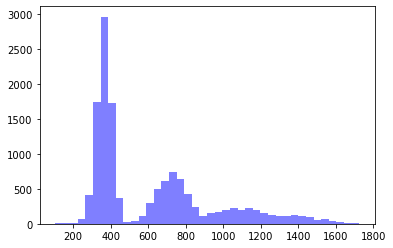

In [21]:
(n, bins, patches) =plt.hist(dt2['wrk_time_int'], 40, facecolor='blue', alpha=0.5)
plt.show()

Becaue the covariance test is very sensitive to the normality of the dependent variable, I will segment the data into three part.

In [22]:
point1 = np.where((bins<600)&(bins>400))
print(point1)
print(n[point1])
# the first cut is at bin 9

(array([ 8,  9, 10, 11, 12]),)
[374.  31.  47. 117. 296.]


In [23]:
pt1 = bins[9]

In [24]:
point2 = np.where((bins<1000)&(bins>800))
print(point2)
print(n[point2])
# the second cut is at bin 19

(array([18, 19, 20, 21, 22]),)
[247. 113. 150. 169. 201.]


In [25]:
pt2 = bins[19]

In [26]:
dt2_1 = dt2[dt2['wrk_time_int']<pt1]
dt2_2 = dt2[(dt2['wrk_time_int']>=pt1)&(dt2['wrk_time_int']<pt2)]
dt2_3 = dt2[dt2['wrk_time_int']>=pt2]

In [64]:
def normalize_X(df,num_var,cat_var):
    norm_var2_1 = df[num_var]
    cat_var2_1 = df[cat_var].reset_index()
    normed_var2_1 = pd.DataFrame(preprocessing.normalize(norm_var2_1))
    normed_var2_1.columns = num_var
    result = pd.concat([normed_var2_1,cat_var2_1],axis = 1)
    return result

In [67]:
numvars = ['seniority', 'salary','wrk_time_int','join_date_int', 'quit_date_int']
catvars = ['employee_id','dept__customer_service', 'dept__data_science',
       'dept__design', 'dept__engineer', 'dept__marketing', 'dept__sales','company_id__1',
       'company_id__2', 'company_id__3', 'company_id__4', 'company_id__5',
       'company_id__6', 'company_id__7', 'company_id__8', 'company_id__9',
       'company_id__10', 'company_id__11', 'company_id__12']
nd_dt_2_1 = normalize_X(dt2_1,numvars,catvars)
nd_dt_2_2 = normalize_X(dt2_2,numvars,catvars)
nd_dt_2_3 = normalize_X(dt2_3,numvars,catvars)

In [77]:
cov_2_1 = nd_dt_2_1[numvars].cov()
cov_2_2 = nd_dt_2_2[numvars].cov()
cov_2_3 = nd_dt_2_3[numvars].cov()
v2_1 = dt2_1.shape[0]-len(numvars)
v2_2 = dt2_2.shape[0]-len(numvars)
v2_3 = dt2_3.shape[0]-len(numvars)

In [102]:
def calculate_chi_sq(cov,v):
    chi_sq = v*(math.log(cov.iloc[1,1])+
          math.log(abs(cov.iloc[2,2]))+
          math.log(abs(cov.iloc[3,3]))+
          math.log(abs(cov.iloc[4,4]))+
          math.log(abs(cov.iloc[0,0]))-
          math.log(abs(det(cov))))
    return chi_sq

In [118]:
chi_sq2_1 = calculate_chi_sq(cov_2_1,v2_1)
chi_sq2_2 = calculate_chi_sq(cov_2_2,v2_2)
chi_sq2_3 = calculate_chi_sq(cov_2_3,v2_3)
(chi_sq2_1,chi_sq2_2,chi_sq2_3)

(308871.98240037536, 147774.79437625504, 104639.89071082471)